<a href="https://colab.research.google.com/github/sumu97/Data-Science-Cheat-Code/blob/main/Kospi_Market_Analysis_sumu97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#코스피 동향분석 및 예측 - sumu97

###Summary
 - 코스피 지수의 단기적 동향을 예측하여, 선물옵션을 통한 단기적 수익실현 및 투자지표로서의 활용이 가능하도록 합니다.
 - 추후 동일한 모델을 부동산 시장 등에 적용시키기 위해, 데이터에 맞춰 쉽게 변형할 수 있도록 작성합니다.
 - 두 개 이상의 예측 모델을 활용하여 그 결과를 토대로 서로의 예측을 개선할 수 있게 합니다.
 - ARIMA 로 Feature 수치를 대략적으로 예측하고, 예측된 데이터를 토대로 Random Forest를 활용해 Target Value를 구합니다.

## 1. EDA

In [263]:
%%capture
from google.colab import drive
import io
import pandas as pd
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
drive.mount('/content/drive')

In [264]:
# 데이터
import datetime
import numpy as np

def get_data(NAME,col):
  # 1. 데이터 가져오기
  df = pd.read_csv('drive/MyDrive/Project/Data_For_Kospi/' + NAME + '.csv')

  # 2. 종가, 거래량, 변동% 제외한 Feature 제거 (중복 Issue 가능성)
  df = df.drop(['오픈','고가','저가'], axis=1)

  # 3. 컬럼명 변경 (원본 데이터마다 Columns 다름, 오류처리구문 추가)
  columns_volp = ['date' , col + '_' + 'enpr' , col + '_' + 'volm' , col + '_' + 'chag']
  columns_volm = ['date' , col + '_' + 'enpr' , col + '_' + 'chag']
  try:
    df.columns = columns_volp
  except:
    df.columns = columns_volm

  # 4. 자료형 변경
  for col in df.columns:
    temp_list = []
    for i in df[col]:
      
      try:
        temp = i.replace('년','') # ER : SILVER ('sv_enpr',) 23.925 에서 에러발생 / float를 replace 하다보니 문제 / 츄라이로 넘겨서 해결
        temp = temp.replace('월','')
        temp = temp.replace('일','')
        temp = temp.replace(' ','-') # 수정 / Debug
        temp = temp.replace(',','')
        temp = temp.replace('K','000')
        temp = temp.replace('%','')
      except:
        temp_list.append(i) # 첨부터 float인 자료형을 list에 저장 / ER : append(temp) 해놓고 뭐가문젠지 한참 찾았네..
        continue # ER : 컬럼에 리스트 적용시 길이가 달라 에러발생 / 아래 츄라이문 하면서 중복적용된게 문제 / 컨티뉴로 돌려보내서 해결
        # ER : 뒷쪽 구문 먹어버려서 'sv_enpr' 에 의미가 다른 값이 들어감
      try:
        temp = float(temp)
        temp_list.append(temp) # float 로 변경된 자료형을 list에 저장
      except:
        try:
          #print(col, i, temp)
          temp = datetime.datetime.strptime(temp, '%Y-%m-%d').date()
          temp_list.append(temp) # datetime 로 변경된 자료형을 list에 저장
        except:
          temp = np.nan
          temp_list.append(temp) # NaN 으로 변경된 자료형을 list에 저장
    df[col] = temp_list # 변경된 리스트를 col 에 저장

  print(NAME,'=',df.shape) # Debug code / 으아아 같은기간 긁었는데 뭐가이렇게 달라

  # 5. 데이터프레임으로 반환
  return df

gd = get_data('GOLD','gd') # 금 시세
sv = get_data('SILVER','sv') # 은 시세
ob = get_data('OIL_BRENT','ob') # 브렌트유 시세
ow = get_data('OIL_WTI','ow') # WTI유 시세
sp = get_data('S&P','sp') # 미국 증시 S&P 500 지수
kd = get_data('KOSDAQ','kd') # 코스닥
kp = get_data('KOSPI','kp') # 코스피(Target)
kr = get_data('KR10','kr') # 한국 10년 국채 수익률
us = get_data('US10','us') # 미국 10년 국채 수익률
jk = get_data('JPY_KRW','jk') # 엔 - 원 환율
uk = get_data('USD_KRW','uk') # 달러 - 원 환율

gd.set_index('date', inplace = True)
sv.set_index('date', inplace = True)
ob.set_index('date', inplace = True)
ow.set_index('date', inplace = True)
sp.set_index('date', inplace = True)
kd.set_index('date', inplace = True)
kp.set_index('date', inplace = True)
kr.set_index('date', inplace = True)
us.set_index('date', inplace = True)
jk.set_index('date', inplace = True)
uk.set_index('date', inplace = True)

df = gd.join(sv, how='outer').join(ob, how='outer').join(ow, how='outer').join(sp , how='outer').join(kd , how='outer').join(kp , how='outer').join(kr , how='outer').join(us , how='outer').join(jk , how='outer').join(uk , how='outer')
print('\n','[joined df] =',df.shape)

# 결측치가 너무 많은 (1500 이상인) Feature 삭제
df = df.drop(['sp_volm','kd_volm','kp_volm'], axis = 1)

# 나머지 결측치는 선형 보간 (interpolation)
df_intp = df.interpolate()

# 보간 후에도 결측치 남아있는 행 삭제 (상위 2행, 시계열 데이터에 영향 주지 않음)
df = df_intp.dropna()

# 중복 값 있는지 확인 -> 없음
print('\n','[Duplicated check]','\n')
df.T.duplicated()

GOLD = (2642, 4)
SILVER = (3140, 4)
OIL_BRENT = (2604, 4)
OIL_WTI = (2635, 4)
S&P = (2537, 4)
KOSDAQ = (2485, 4)
KOSPI = (2484, 4)
KR10 = (3168, 3)
US10 = (3012, 3)
JPY_KRW = (2632, 3)
USD_KRW = (2632, 3)

 [joined df] = (3511, 29)

 [Duplicated check] 



gd_enpr    False
gd_volm    False
gd_chag    False
sv_enpr    False
sv_volm    False
sv_chag    False
ob_enpr    False
ob_volm    False
ob_chag    False
ow_enpr    False
ow_volm    False
ow_chag    False
sp_enpr    False
sp_chag    False
kd_enpr    False
kd_chag    False
kp_enpr    False
kp_chag    False
kr_enpr    False
kr_chag    False
us_enpr    False
us_chag    False
jk_enpr    False
jk_chag    False
uk_enpr    False
uk_chag    False
dtype: bool

## 2. Test - ARIMA Model

  - 전통적인 시계열 예측 방법
    - AR(Autoregression) 모델 : 자신의 과거를 정보로 사용하는 개념
    - MA(Moving Average) 모델 : 이번 항에서의 오차를 이용, 현재 항의 상태를 추론
    - 두가지가 합쳐진 것을 ARMA 모델이라고 함
    - ARIMA(Autoregressice Integrated Moving Average)모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법

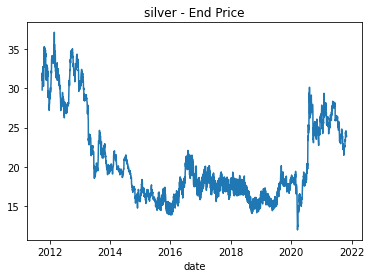

In [ ]:
import matplotlib.pyplot as plt
df_enpr.plot()
plt.title('silver - End Price')
plt.show()

In [ ]:
step = 10 # 테스트 데이터 분리 할 일자 수
test_df = df_enpr.drop(df_enpr.index[-1 * step :-1])
test_df = test_df.drop(test_df.index[-1])
test_df

date
2011-10-04    29.795
2011-10-05    30.317
2011-10-06    31.970
2011-10-07    30.958
2011-10-09    31.685
               ...  
2021-10-18    23.264
2021-10-19    23.883
2021-10-20    24.445
2021-10-21    24.170
2021-10-22    24.449
Name: sv_enpr, Length: 3499, dtype: float64

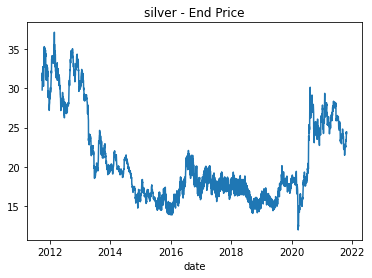

In [ ]:
import matplotlib.pyplot as plt
test_df.plot()
plt.title('silver - End Price')
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(test_df.values, order = (5,1,2))
# AR = 3, 차분 = 1, MA = 2 파라미터로 ARIMA 모델을 학습한다.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# ARIMA 모델 학습
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3498
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2489.170
Method:                       css-mle   S.D. of innovations              0.493
Date:                Tue, 09 Nov 2021   AIC                           4996.341
Time:                        11:18:18   BIC                           5051.780
Sample:                             1   HQIC                          5016.127
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.005     -0.397      0.691      -0.011       0.007
ar.L1.D.y      0.0499      0.070      0.710      0.477      -0.088       0.188
ar.L2.D.y     -0.6488      0.025    -26.201      0.0

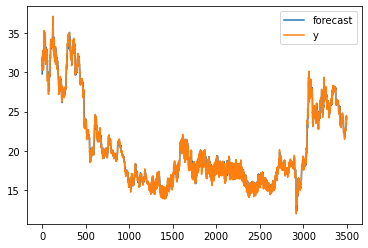

In [ ]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict()

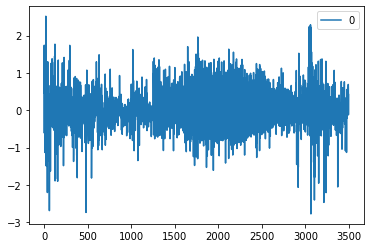

In [ ]:
# 실제값과 예측값 사이의 오차 변동
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [ ]:
# 모델 평가
forecast_data = model_fit.forecast(steps=step) 

test_df_c = df_enpr[len(df_enpr) - step:]
test_df_c

date
2021-10-23    24.4510
2021-10-24    24.4530
2021-10-25    24.5920
2021-10-26    24.0880
2021-10-27    24.1910
2021-10-28    24.1200
2021-10-29    23.9490
2021-10-30    23.8945
2021-10-31    23.8400
2021-11-01    23.9250
Name: sv_enpr, dtype: float64

In [ ]:
# 마지막 5월의 예측 데이터
pred_y = forecast_data[0].tolist()

# 실제 5월의 데이터
test_y = test_df_c.values

# 마지막 5월의 예측 데이터 최소값
pred_y_lower = []

# 마지막 5월의 예측 데이터 최대값
pred_y_upper = []

In [ ]:
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

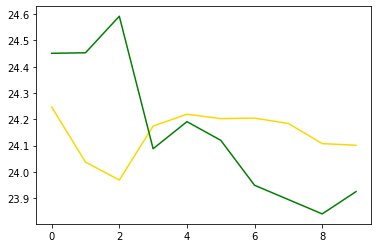

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프
plt.plot(pred_y, color = 'gold')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

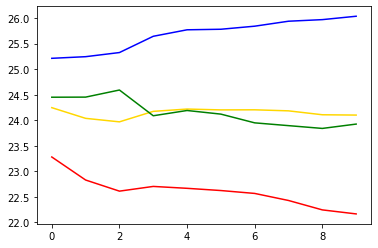

In [ ]:
# 5,1,2 모델이 예측한 가격 그래프 (최저, 최고)
plt.plot(pred_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

In [ ]:
# 위의 내용을 df_enpr, steps 로 함수화
def arima(col,step=10): # df.gd_enpr,10
  from statsmodels.tsa.arima_model import ARIMA
  import statsmodels.api as sm
  test_df = col.drop(col.index[-1 * step :-1])
  test_df = test_df.drop(test_df.index[-1])

  model = ARIMA(test_df.values, order = (5,1,2))
  model_fit = model.fit(trend = 'c', full_output = True, disp = True)

  forecast_data = model_fit.forecast(steps=step) 

  test_df_c = col[len(col) - step:]
  test_df_c

  # 예측 데이터
  pred_y = forecast_data[0].tolist()

  # 실제 데이터
  test_y = test_df_c.values

  # 예측 데이터 최소값
  pred_y_lower = []

  # 예측 데이터 최대값
  pred_y_upper = []

  for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)
  
  	
  #fig = plt.figure(figsize=(5,5))

  # 모델이 예측한 가격 그래프
  plt.plot(pred_y, color = 'gold')

  # 모델이 예측한 최저 가격 그래프
  #plt.plot(pred_y_lower, color = 'red')

  # 모델이 예측한 최고 가격 그래프
  #plt.plot(pred_y_upper, color = 'blue')

  # 실제 가격 그래프
  plt.plot(test_y, color = 'green')


Progress:   0%|          | 0/26 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianI

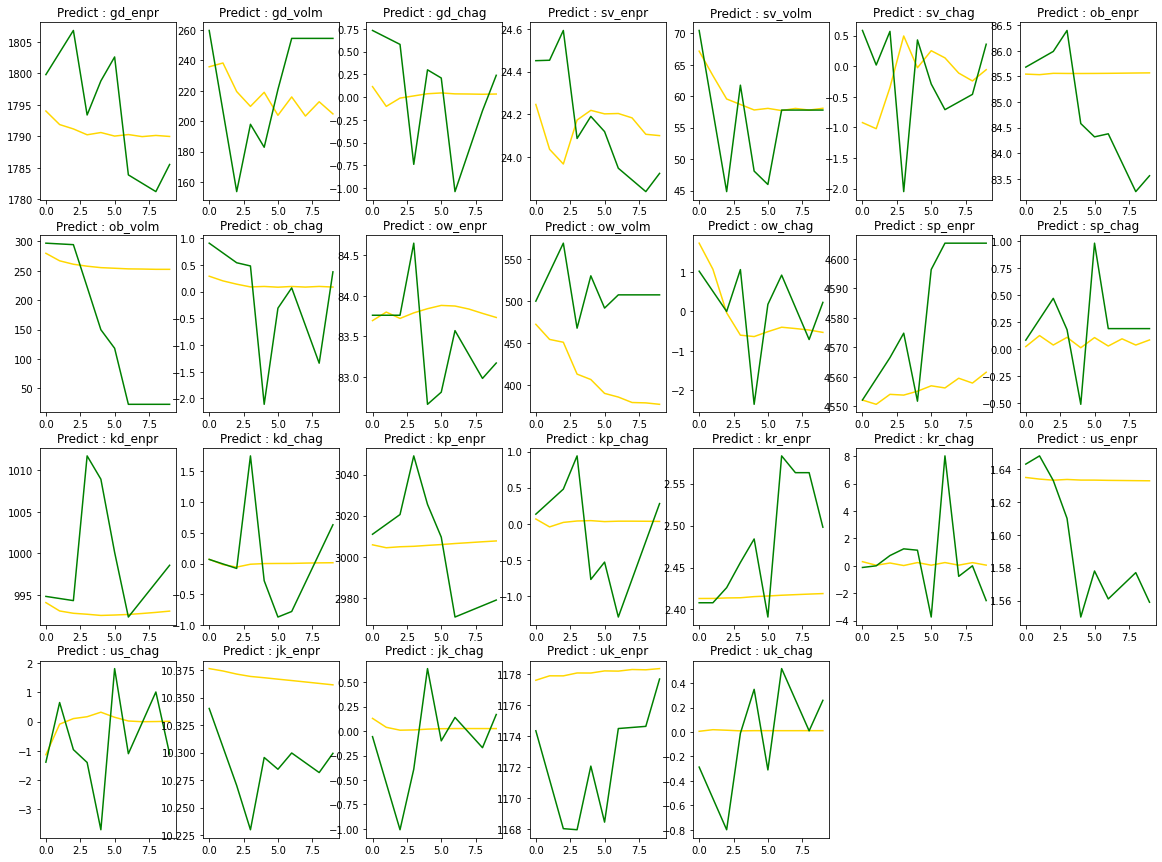

In [ ]:
from tqdm import notebook

grid = (1,3)
n = 0

fig = plt.figure(figsize=(20,15))
for i in notebook.tqdm(df.columns, desc='Progress'):
    n += 1
    plt.subplot(4,7,n)
    plt.title("Predict : "+ i)
    arima(df[i])


plt.show()

ARIMA 모델이 그럭저럭 예측하는것을 확인했다.

##3. Apply - ARIMA Model

In [265]:
# 데이터 축소 함수 (검증용)

def cut_data(df, first = 0, last = 0): # cut_data(df, '2021-09-30', '2021-10-30')
  if first == 0:
    first = str(df.index[0])
  if last == 0:
    last = str(df.index[-1])

  cdf = (df.index >= date.fromisoformat(first)) & (df.index <= date.fromisoformat(last))
  return df[cdf]

# ARIMA 예측 함수
def arima(col,step=10): # df.gd_enpr,10
  from statsmodels.tsa.arima_model import ARIMA
  import statsmodels.api as sm

  try:
    model = ARIMA(col.values, order = (5,1,2)) # AR, 차분, MA
    model_fit = model.fit(trend = 'c', full_output = False, disp = False)
  except:
    try:
      model = ARIMA(col.values, order = (2,1,2)) # AR, 차분, MA
      model_fit = model.fit(trend = 'c', full_output = False, disp = False)
    except:
      model = ARIMA(col.values, order = (1,0,1)) # AR, 차분, MA
      model_fit = model.fit(trend = 'c', full_output = False, disp = False)

  forecast_data = model_fit.forecast(steps=step) 

  pred_y = forecast_data[0].tolist()
  return pred_y

결과 검증 및 비교를 위해 데이터 축소

In [266]:
cdf = cut_data(df, 0, 0) # 최초 / 최종

In [267]:
cdf.index[-1]

datetime.date(2021, 11, 1)

In [268]:
cdf = cdf.drop(['gd_chag', 'us_chag','jk_chag','uk_chag'], axis=1) # ARIMA 모델 적용시 에러유발 - 삭제

예측 데이터프레임 생성

In [269]:
from tqdm import notebook

pred_df = pd.DataFrame([])
for col in notebook.tqdm(cdf.columns, desc='Progress'):
  pred_df[col] = arima(cdf[col])
  print('Now processing : ',col)

Progress:   0%|          | 0/22 [00:00<?, ?it/s]

Now processing :  gd_enpr
Now processing :  gd_volm
Now processing :  sv_enpr
Now processing :  sv_volm
Now processing :  sv_chag
Now processing :  ob_enpr
Now processing :  ob_volm
Now processing :  ob_chag
Now processing :  ow_enpr
Now processing :  ow_volm
Now processing :  ow_chag
Now processing :  sp_enpr
Now processing :  sp_chag
Now processing :  kd_enpr
Now processing :  kd_chag
Now processing :  kp_enpr
Now processing :  kp_chag
Now processing :  kr_enpr
Now processing :  kr_chag
Now processing :  us_enpr
Now processing :  jk_enpr
Now processing :  uk_enpr


In [270]:
pred_df # Test dataset

,gd_enpr,gd_volm,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kp_enpr,kp_chag,kr_enpr,kr_chag,us_enpr,jk_enpr,uk_enpr
0,1786.345065,247.497425,23.871051,56.643197,0.281246,83.548102,97.112416,0.109875,83.185032,477.942570,0.450774,4605.552346,0.141140,999.179540,0.200175,2979.300166,0.023757,2.499854,-0.007339,1.559458,10.297504,1177.718158
1,1786.144846,234.448906,23.907563,56.630164,0.154937,83.534780,148.504318,0.140432,83.191587,449.865936,0.068620,4605.249308,0.048645,999.933736,0.100844,2981.825290,0.060001,2.502813,0.161628,1.559674,10.296851,1177.770224
2,1786.444432,237.386874,23.949663,56.163415,0.004068,83.520853,185.075837,0.112475,83.172642,429.710142,-0.252541,4608.708314,0.106994,1000.272229,0.078195,2982.778244,0.083917,2.507146,0.301058,1.560141,10.295216,1177.814430
3,1786.281582,229.293389,23.936276,56.382696,-0.079042,83.481895,207.377138,0.096759,83.188809,414.216940,-0.581531,4606.228350,0.046698,1000.576580,0.085042,2983.846071,0.095410,2.508331,0.186337,1.560628,10.293416,1177.761082
4,1786.641117,234.051459,23.879580,56.128103,-0.205978,83.433392,221.202034,0.088870,83.217166,403.712968,-0.510074,4610.870272,0.098697,1000.723872,0.052824,2984.483310,0.043327,2.509628,0.174874,1.560796,10.292125,1177.725062
5,1786.552463,228.545707,23.882378,56.365275,-0.110156,83.380613,229.809863,0.090447,83.248276,397.819743,-0.552707,4608.274114,0.045054,1000.891080,0.033692,2985.136582,0.038994,2.510601,0.133069,1.560977,10.290689,1177.678926
6,1786.774862,232.040997,23.898251,56.175447,-0.025612,83.328582,235.030636,0.086806,83.268091,394.815602,-0.429008,4612.488789,0.086323,1000.999350,0.023966,2985.555656,0.036986,2.511919,0.167513,1.561057,10.289324,1177.647133
7,1786.725923,228.767225,23.894151,56.379912,0.011955,83.282372,238.367092,0.090397,83.273262,393.669199,-0.517546,4610.826469,0.050842,1001.126940,0.020042,2985.986652,0.035132,2.512915,0.139212,1.561110,10.287936,1177.610072
8,1786.872734,230.950022,23.893785,56.225932,0.009861,83.245468,240.348925,0.087190,83.263581,393.595959,-0.460943,4613.725099,0.079498,1001.241003,0.016504,2986.347792,0.029541,2.514129,0.171423,1.561125,10.286542,1177.586301
9,1786.861012,229.228721,23.906185,56.397778,0.005658,83.219925,241.660101,0.090596,83.243664,394.037497,-0.551254,4613.643711,0.055965,1001.369936,0.014587,2986.713297,0.030315,2.515022,0.141034,1.561118,10.285152,1177.557968


##4. Feature Engineering

Kospi 지수의 변동량에 따라 0에서 3까지의 정수값을 갖게 만들어보자.

In [271]:
df.columns

Index(['gd_enpr', 'gd_volm', 'gd_chag', 'sv_enpr', 'sv_volm', 'sv_chag',
       'ob_enpr', 'ob_volm', 'ob_chag', 'ow_enpr', 'ow_volm', 'ow_chag',
       'sp_enpr', 'sp_chag', 'kd_enpr', 'kd_chag', 'kp_enpr', 'kp_chag',
       'kr_enpr', 'kr_chag', 'us_enpr', 'us_chag', 'jk_enpr', 'jk_chag',
       'uk_enpr', 'uk_chag'],
      dtype='object')

In [272]:
df.kp_chag.describe()

count    3509.000000
mean        0.017162
std         0.931079
min        -8.390000
25%        -0.410000
50%         0.040000
75%         0.500000
max         8.600000
Name: kp_chag, dtype: float64

kp_chag 값에 따라 0은 -0.41 미만, 3은 0.5 이상으로 값을 만들면 되겠다.

In [273]:
temp_list = []
for i in df.kp_chag:
  temp = round(i,2)
  
  if temp <= -0.41:
    n = 0
  elif temp <= 0.04:
    n = 1
  elif temp < 0.5:
    n = 2
  else:
    n = 3
  
  temp_list.append(n)

df['point'] = temp_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [274]:
df2 = df.copy() # df 백업 1

In [275]:
df = df2.copy() # df 백업 2

In [276]:
# df 에서 point 직접적으로 관련된 넘 제거
df = df.drop(['kp_chag','kp_enpr'], axis=1)

In [277]:
target = 'point'

train =  cut_data(df, 0, '2018-10-30')
test =  cut_data(df, '2018-10-31')

val = cut_data(train, '2016-10-30')
train = cut_data(train, 0, '2016-10-29')

train.shape, val.shape, test.shape

((1704, 25), (719, 25), (1086, 25))

In [278]:
# Train 에서 Target drop
features = train.drop(columns=[target]).columns

In [279]:
# X, y 로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [280]:
X_train.head()

,gd_enpr,gd_volm,gd_chag,sv_enpr,sv_volm,sv_chag,ob_enpr,ob_volm,ob_chag,ow_enpr,ow_volm,ow_chag,sp_enpr,sp_chag,kd_enpr,kd_chag,kr_enpr,kr_chag,us_enpr,us_chag,jk_enpr,jk_chag,uk_enpr,uk_chag
date,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-04,1614.70,0.160,-2.49,29.795,0.04,-3.11,99.790,264.830,-1.89,75.670,428.110,-2.50,1123.950,2.250,436.130,-3.010,3.80,-3.31,1.8170,3.890,15.59240,1.150,1198.900,1.560
2011-10-05,1640.30,0.110,1.59,30.317,0.18,1.75,102.730,215.940,2.95,79.680,336.070,5.30,1144.030,1.790,421.180,-3.430,3.78,-0.53,1.8910,4.070,15.46080,-0.840,1187.000,-0.990
2011-10-06,1651.90,0.040,0.71,31.970,0.01,5.45,105.730,192.570,2.92,82.590,386.090,3.65,1164.970,1.830,431.180,2.370,3.81,0.79,1.9920,5.340,15.43820,-0.150,1183.950,-0.260
2011-10-07,1634.50,0.070,-1.05,30.958,0.06,-3.17,105.880,170.250,0.14,82.980,377.540,0.47,1155.460,-0.820,442.640,2.660,3.82,0.26,2.0750,4.170,15.26130,-1.150,1171.000,-1.090
2011-10-09,1652.05,0.065,0.55,31.685,0.06,2.35,107.415,166.435,1.52,84.195,321.185,1.70,1175.175,1.295,448.275,2.605,3.83,0.39,2.0725,1.955,15.24885,-0.655,1169.475,-0.675


##5. Model Selection

In [281]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas.util.testing as tm # 디버그 문구때문에 추가함
from xgboost import XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model 평가
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

In [282]:
# 모델 (RandomForestClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=25, min_samples_leaf=3, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_val)

훈련 정확도:  0.9882629107981221
검증 정확도:  0.4422809457579972


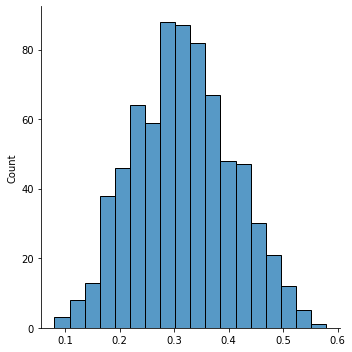

In [283]:
sns.displot(pipe.predict_proba(X_val)[:, 1]);

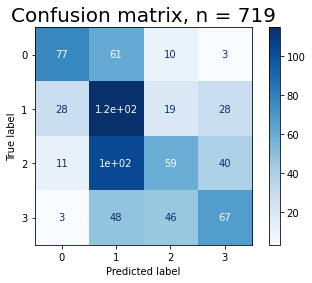

In [284]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=20)
plt.show()

In [285]:
cm = pcm.confusion_matrix
cm

array([[ 77,  61,  10,   3],
       [ 28, 115,  19,  28],
       [ 11, 104,  59,  40],
       [  3,  48,  46,  67]])

In [286]:
TP = cm[0][0] + cm[1][1] + cm[1][0] + cm[0][1]
TN = cm[2][2] + cm[2][3] + cm[3][2] + cm[3][3]
FP = cm[2][0] + cm[3][0] + cm[2][1] + cm[3][1]
FN = cm[0][2] + cm[0][3] + cm[1][2] + cm[1][3]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
Beta = 1
F_score = (1+Beta**2) * (Precision * Recall) / (Beta**2 * Precision + Recall)
print('Precision = ',Precision)
print('Recall = ',Recall)
print('F1 score = ', F_score)
# 틀림 : 계산 우짜는지 모르겠음 그냥 함수 먹입시다!

Precision =  0.6286353467561522
Recall =  0.8240469208211144
F1 score =  0.7131979695431473


In [287]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57       151
           1       0.35      0.61      0.44       190
           2       0.44      0.28      0.34       214
           3       0.49      0.41      0.44       164

    accuracy                           0.44       719
   macro avg       0.48      0.45      0.45       719
weighted avg       0.47      0.44      0.44       719



0,1,2,3 으로 나눠지게되서 THRESHOLD 조정은 힘들것같다.

In [288]:
# 모델 (XGBClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    XGBClassifier(n_estimators=100, min_child_weight=1)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_val)

훈련 정확도:  0.7552816901408451
검증 정확도:  0.41585535465924894


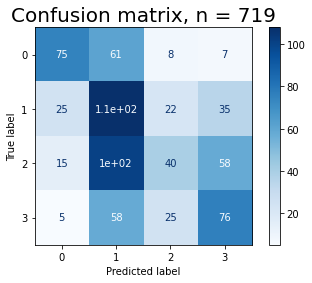

In [289]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=20)
plt.show()

In [290]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       151
           1       0.33      0.57      0.42       190
           2       0.42      0.19      0.26       214
           3       0.43      0.46      0.45       164

    accuracy                           0.42       719
   macro avg       0.45      0.43      0.42       719
weighted avg       0.44      0.42      0.41       719



지금봐서는 랜덤포레스트가 나은듯 싶다.

In [291]:
# 기존 모델 (RandomForestClassifier) 학습 
pipe = make_pipeline(
    OrdinalEncoder(),  
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, max_depth=25, min_samples_leaf=3, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
pred = pipe.predict(X_val)

훈련 정확도:  0.9882629107981221
검증 정확도:  0.4422809457579972


In [299]:
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)
dists = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)
}
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)
clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


In [300]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.779149698434337, 'randomforestclassifier__n_estimators': 138, 'simpleimputer__strategy': 'most_frequent'}
MAE:  0.9113849765258216


In [301]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,6,37,29,42,16,20,13,39,4,41,43,26,25,40,0,8,18,31,3,7,5,49,22,1,15,12,35,48,32,44,14,36,47,46,45,11,10,34,17,33,30,21,27,23,24,2,38,19,9,28
mean_fit_time,1.59472,1.64458,4.86987,6.21249,4.14122,3.42484,1.77381,1.56916,2.35774,4.35957,3.69719,9.74995,5.75035,9.52258,9.62682,2.50032,6.88366,7.31573,2.6085,4.53868,5.02293,5.30367,4.61564,1.33463,4.64795,3.43895,4.82813,4.8218,1.77605,4.75906,3.16381,1.79564,6.20408,1.20058,1.82803,0.47536,1.54467,0.877144,1.75756,0.902364,3.01617,2.58821,1.76299,2.33782,1.95528,1.66965,1.98479,1.22359,0.697161,0.580538
std_fit_time,0.00794774,0.0286393,0.0187198,0.0628257,0.0385435,0.104499,0.0482831,0.0446597,0.0381615,0.0725799,0.0162607,0.276662,0.16892,0.282705,0.300122,0.0219005,0.0878381,0.196591,0.0582805,0.169403,0.0537535,0.883647,0.134079,0.0369539,0.0421606,0.0435619,0.121686,0.139332,0.0424966,0.132808,0.0861417,0.0192843,0.193217,0.0111434,0.0349822,0.00966523,0.0316573,0.021799,0.0114986,0.00811555,0.012854,0.021642,0.0409899,0.0481623,0.0449781,0.0252007,0.0440096,0.0114447,0.0128233,0.0145055
mean_score_time,0.0313324,0.0307261,0.0832789,0.0722895,0.0446085,0.0360642,0.0202069,0.0194638,0.0277944,0.0570655,0.0979877,0.0929111,0.0810666,0.103498,0.103179,0.058054,0.108011,0.0834648,0.0270445,0.0594925,0.0982969,0.0661626,0.0503693,0.0185284,0.10614,0.0623883,0.0740999,0.0720963,0.0190496,0.0963036,0.0635315,0.0364861,0.107718,0.0512098,0.0347462,0.0202991,0.0399864,0.027129,0.0812677,0.0339511,0.0928802,0.0921364,0.0575867,0.0933728,0.0757194,0.0809102,0.0771259,0.0612958,0.0442915,0.0371825
std_score_time,0.00245606,0.000500681,0.00253046,0.00801737,0.00261056,0.00220911,0.000926864,0.0014705,0.00196183,0.00295564,0.00235348,0.00608104,0.00498021,0.0061132,0.0075452,0.0029783,0.00879481,0.00777634,0.000682567,0.00235893,0.00946498,0.0161743,0.00820629,0.00152839,0.00387679,0.00453069,0.00192886,0.00471407,0.000919681,0.00663688,0.00359959,0.00131023,0.00515383,0.00675694,0.00187385,0.000425006,0.00499155,0.00218212,0.00549657,0.00205237,0.00476245,0.0048621,0.00335375,0.00661186,0.00416605,0.00397201,0.0062421,0.00273746,0.00235007,0.00212583
param_randomforestclassifier__max_depth,5,5,5,10,10,20,None,None,10,10,5,None,20,None,None,5,10,20,15,None,10,15,None,None,10,10,15,15,20,15,20,10,20,5,15,5,15,None,5,10,10,10,20,20,20,15,None,10,10,None
param_randomforestclassifier__max_features,0.77915,0.735251,0.829747,0.908777,0.936173,0.907468,0.902852,0.8343,0.909998,0.716884,0.438455,0.96822,0.587705,0.846486,0.856575,0.555417,0.608805,0.952272,0.997794,0.681028,0.474447,0.757129,0.930079,0.744248,0.374157,0.506467,0.546821,0.542799,0.93552,0.395494,0.396558,0.439017,0.513036,0.287421,0.432915,0.213678,0.29921,0.213512,0.170024,0.203519,0.227277,0.16844,0.20708,0.134467,0.162533,0.118957,0.156916,0.112077,0.0806475,0.0651634
param_randomforestclassifier__n_estimators,138,149,408,310,200,155,80,73,118,260,497,408,362,449,452,282,484,318,110,255,424,306,201,72,492,272,326,326,77,423,279,162,443,220,149,94,162,112,393,148,438,426,260,400,335,349,339,281,196,146
param_simpleimputer__strategy,most_frequent,mean,most_frequent,most_frequent,median,mean,mean,most_frequent,median,mean,mean,median,most_frequent,median,mean,mean,median,most_frequent,most_frequent,mean,median,mean,most_frequent,mean,most_frequent,median,mean,mean,most_frequent,median,mean,median,mean,mean,median,median,most_frequent,median,median,mean,most_frequent,mean,median,median,median,most_frequent,most_frequent,mean,most_frequent,median
params,"{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclass

In [302]:
pipe = clf.best_estimator_

In [303]:
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

훈련 정확도:  0.6156103286384976
검증 정확도:  0.45897079276773295


##6. Random Forest